In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#Plot the animation
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
pos=np.load('data_npy/100_3.npy')
vid=np.load('data_video/100_3.npy')
midline=np.load('data_midline/100_3_consistent.npy')
velocity =midline[1:,:,1,:]-midline[:-1,:,1,:]
head=midline[:,:,0,:]-midline[:,:,1,:]
tail=midline[:,:,2,:]-midline[:,:,1,:]

phi= np.arctan2(head[:,:,1], head[:,:,0])
# angular_speed= angle_between_2vec(head[1:,:,:], head[:-1,:,:], axis=2) 
L1=np.linalg.norm(head, axis=2)
L2=np.linalg.norm(tail, axis=2)
Observer_index=0
R=500
Observed_vector=midline[:,None,:,1,:]-midline[:,:,None,1,:]
Observed_distance=np.linalg.norm(Observed_vector, axis=3)
# Observed_phi=angle_between_2vec(head[:,:,None,:], Observed_vector, axis=3)
Observed_index=Observed_distance<=R

In [3]:
def get_observations_debug(midline, observer_index, R):
    """
    取得指定魚在每個時間點觀察到的其他魚的座標與距離（座標為觀察者本地座標）。
    midline: (T, N, 3, 2) 時間、魚數、身體點、xy座標
    observer_index: 指定觀察者的index (int)
    R: 觀察半徑
    回傳: List，每個元素為該時間點觀察到的魚的index與本地座標
    """
    T, N = midline.shape[0], midline.shape[1]
    observer_pos = midline[:, observer_index, 1, :]  # 取身體中心點
    all_pos = midline[:, :, 1, :]
    observations = []
    for t in range(T):
        # 計算距離
        vec = all_pos[t] - observer_pos[t]
        dist = np.linalg.norm(vec, axis=1)
        # 找出在半徑R內且不是自己
        mask = (dist <= R) & (np.arange(N) != observer_index)
        observed_indices = np.where(mask)[0]
        observed_coords_local = vec[mask]  # 本地座標
        observations.append({
            'time': t,
            'observed_indices': observed_indices,
            'observed_coords': observed_coords_local,
            'distances': dist[mask]
        })
    return observations

# 範例：取得第0隻魚在每個時間點觀察到的其他魚（本地座標）
observations = get_observations_debug(midline, observer_index=Observer_index, R=R)
#print frame 0,1,10,20
for i in [0, 1, 10, 20]:
    obs = observations[i]
    print(f"Time {obs['time']}:")
    for idx, coord, dist in zip(obs['observed_indices'], obs['observed_coords'], obs['distances']):
        print(f"  Fish {idx} at local coords {coord}, distance {dist:.2f}")

Time 0:
  Fish 6 at local coords [346.88428   20.908936], distance 347.51
  Fish 9 at local coords [-254.6908  -396.36304], distance 471.14
  Fish 16 at local coords [-17.138916 327.9983  ], distance 328.45
  Fish 28 at local coords [-385.66016  265.40576], distance 468.16
  Fish 32 at local coords [ -67.39795 -206.62915], distance 217.34
  Fish 35 at local coords [-20.097168 107.00464 ], distance 108.88
  Fish 37 at local coords [-103.754395 -428.9259  ], distance 441.30
  Fish 44 at local coords [-346.85657  351.32715], distance 493.70
  Fish 64 at local coords [ 130.3601  -212.21313], distance 249.05
  Fish 70 at local coords [-368.2235  -120.14258], distance 387.33
  Fish 71 at local coords [ 269.95972 -168.18799], distance 318.07
  Fish 89 at local coords [178.6897  170.61987], distance 247.07
  Fish 98 at local coords [ -24.001709 -193.46509 ], distance 194.95
Time 1:
  Fish 6 at local coords [348.5686    11.372803], distance 348.75
  Fish 9 at local coords [-242.82227 -409.43213

## getting observation

Processing time points: 100%|██████████| 19526/19526 [00:35<00:00, 555.72it/s]


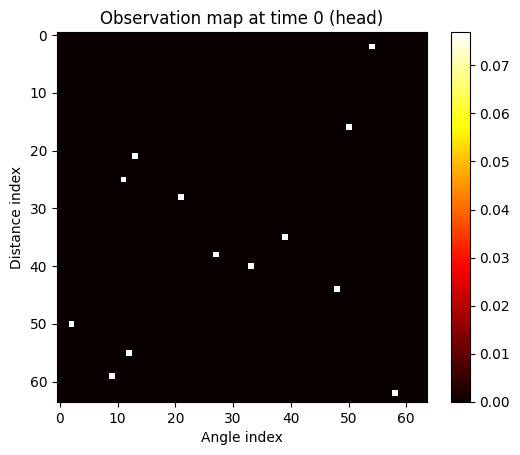

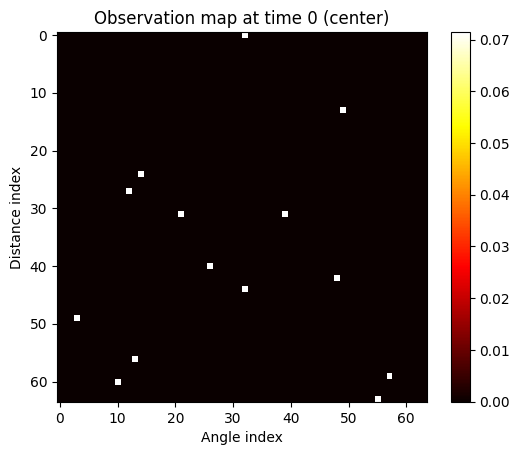

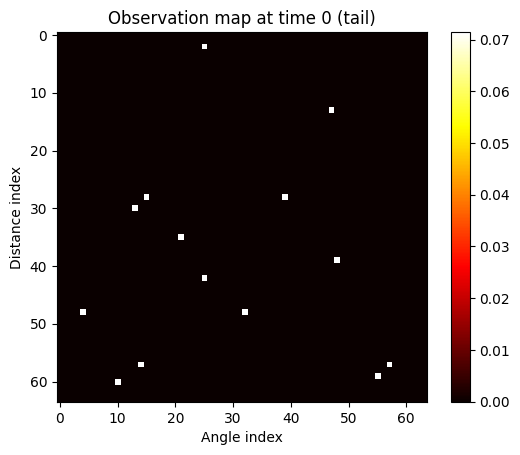

In [4]:
grid_size = 64

    # we get observations of a fish at each time point
    # which it does not need to know the index of other fish it observes
    # but it knows the local coordinates of the fish it observes
    # and there angle with respect to the observer
    #then map it into a 2d array of size (grid_size, grid_size)
    #with row as distance and column as angle
    # and we further make 3 observations map with respect to head, tail and center
    #so the output will be (3, grid_size, grid_size)
    #reminds: the fish can also observe itself(head, center, tail), to ensure where it is facing, and it will be at the center of the map
    # 取得 head, center, tail 的座標

    # the 3 observation maps should be related to:
    # head: head_pos - center_pos of the observer
    # center: center_pos - center_pos of the observer
    # tail: tail_pos - center_pos of the observer
def get_observations(midline, observer_index, R, grid_size=64):
    T, N = midline.shape[0], midline.shape[1]
    
    # Extract positions
    head_pos = midline[:, :, 0, :]  # (T, N, 2)
    center_pos = midline[:, :, 1, :]  # (T, N, 2)
    tail_pos = midline[:, :, 2, :]  # (T, N, 2)
    
    observer_pos = midline[:, observer_index, 1, :]  # (T, 2)

    # Initialize observation maps
    obs_maps = np.zeros((T, 3, grid_size, grid_size))

    # Angle and distance bins
    angle_bins = np.linspace(-np.pi, np.pi, grid_size + 1)
    distance_bins = np.linspace(0, R, grid_size + 1)

    # Iterate through each time point
    for t in tqdm(range(T), desc="Processing time points"):
        for n in range(N):
            # if n == observer_index:
            #     continue

            # Calculate vectors
            head_vector = head_pos[t, n] - observer_pos[t]
            center_vector = center_pos[t, n] - observer_pos[t]
            tail_vector = tail_pos[t, n] - observer_pos[t]

            #print the head_vector, center_vector, tail_vector for the observer index at time = 0
            """ 
            if t == 0 and n == observer_index:
                print("Head vector:", head_vector)
                print("Center vector:", center_vector)
                print("Tail vector:", tail_vector)
            """

            # Calculate distances and angles
            head_distance = np.linalg.norm(head_vector)
            center_distance = np.linalg.norm(center_vector)
            tail_distance = np.linalg.norm(tail_vector)

            head_angle = np.arctan2(head_vector[1], head_vector[0])
            center_angle = np.arctan2(center_vector[1], center_vector[0])
            tail_angle = np.arctan2(tail_vector[1], tail_vector[0])

            # Convert distances and angles to indices
            head_distance_index = np.digitize(head_distance, distance_bins) - 1
            center_distance_index = np.digitize(center_distance, distance_bins) - 1
            tail_distance_index = np.digitize(tail_distance, distance_bins) - 1

            head_angle_index = np.digitize(head_angle, angle_bins) - 1
            center_angle_index = np.digitize(center_angle, angle_bins) - 1
            tail_angle_index = np.digitize(tail_angle, angle_bins) - 1

            # Increment observation maps
            if 0 <= head_distance_index < grid_size and 0 <= head_angle_index < grid_size:
                obs_maps[t, 0, head_distance_index, head_angle_index] += 1
            if 0 <= center_distance_index < grid_size and 0 <= center_angle_index < grid_size:
                obs_maps[t, 1, center_distance_index, center_angle_index] += 1
            if 0 <= tail_distance_index < grid_size and 0 <= tail_angle_index < grid_size:
                obs_maps[t, 2, tail_distance_index, tail_angle_index] += 1

    # Normalize observation maps
    obs_maps /= np.sum(obs_maps, axis=(2, 3), keepdims=True)
    obs_maps = np.nan_to_num(obs_maps)  # Replace NaN with 0
    obs_maps = np.clip(obs_maps, 0, 1)  # Ensure values are between 0 and 1

    return obs_maps

# 範例：取得第0隻魚在每個時間點的觀察地圖
obs_maps = get_observations(midline, observer_index=Observer_index, R=R, grid_size=grid_size)
# 打印第0個時間點的觀察地圖
for ref_idx, ref_name in enumerate(['head', 'center', 'tail']):
    plt.imshow(obs_maps[0, ref_idx], cmap='hot', interpolation='nearest')
    plt.title(f'Observation map at time 0 ({ref_name})')
    plt.colorbar()
    plt.xlabel('Angle index')
    plt.ylabel('Distance index')
    plt.show()


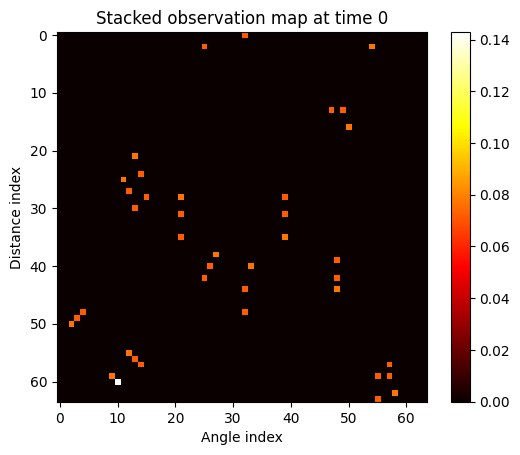

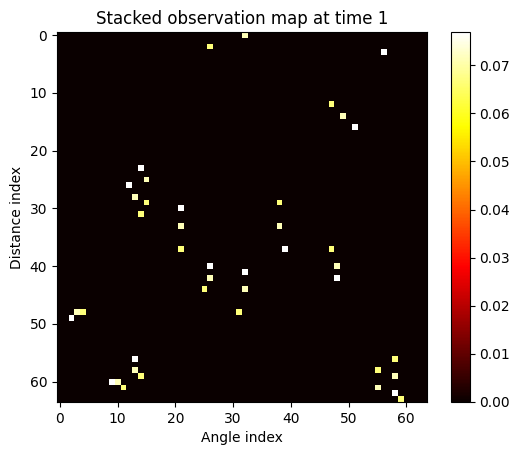

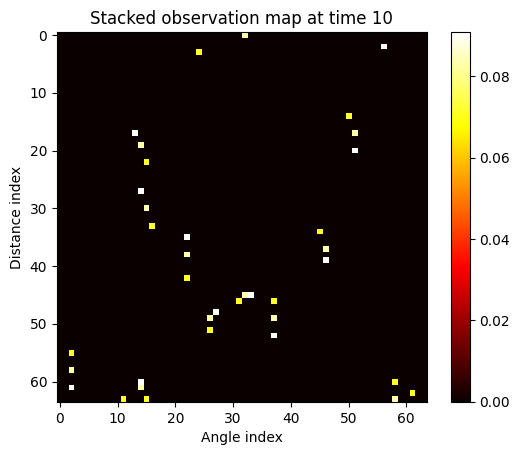

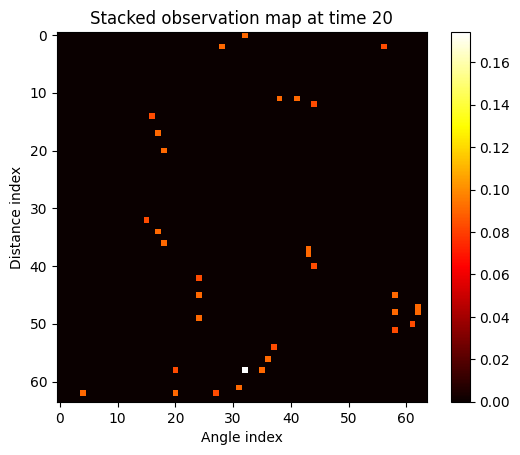

In [5]:
# stack 3 map into one map and print it
#input wil be (T, 3, grid_size, grid_size)
#output will be (T, grid_size, grid_size)
def stack_obs_maps(obs_maps):
    """
    將觀察地圖堆疊成一個地圖，將三個觀察點的地圖合併。
    obs_maps: (T, 3, grid_size, grid_size)
    回傳: (T, grid_size, grid_size)
    """
    return np.sum(obs_maps, axis=1)

    
obs_maps_stacked = stack_obs_maps(obs_maps)
# 打印堆疊後的觀察地圖
# and only frame 0
for t in [0, 1, 10, 20]:
    plt.imshow(obs_maps_stacked[t], cmap='hot', interpolation='nearest')
    plt.title(f'Stacked observation map at time {t}')
    plt.colorbar()
    plt.xlabel('Angle index')
    plt.ylabel('Distance index')
    plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# Show the animation as html
from IPython.display import HTML

# plot the animation of head, center and tail of the fish 0 respectively for each time point
# by using the data weget in obs_map
def plot_fish_animation(midline, observer_index=0, interval=100,obs_maps=None,grid_size=64, R=500):
    
    if obs_maps is None:
        obs_maps = get_observations(midline, observer_index=observer_index, R=R)
    T, N = midline.shape[0], midline.shape[1]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal')
    ax.set_title(f'Fish {observer_index} Observations Animation')
    ax.set_xlabel('X Position (local)')
    ax.set_ylabel('Y Position (local)')

    # 初始化三個魚的頭部、中心和尾部位置
    head_line, = ax.plot([], [], 'ro', label='Head')
    center_line, = ax.plot([], [], 'go', label='Center')
    tail_line, = ax.plot([], [], 'bo', label='Tail')

    # 初始化觀察地圖
    obs_images = []
    for ref_idx, ref_name in enumerate(['head', 'center', 'tail']):
        obs_img = ax.imshow(obs_maps[0, ref_idx], cmap='hot', interpolation='nearest', alpha=0.5)
        obs_images.append(obs_img)
    ax.legend()

    def init():
        head_line.set_data([], [])
        center_line.set_data([], [])
        tail_line.set_data([], [])
        for img in obs_images:
            img.set_array(np.zeros_like(img.get_array()))
        return head_line, center_line, tail_line, *obs_images
    def update(frame):
        head_pos = midline[frame, observer_index, 0, :]
        center_pos = midline[frame, observer_index, 1, :]
        tail_pos = midline[frame, observer_index, 2, :]
        
        head_line.set_data([head_pos[0]], [head_pos[1]])
        center_line.set_data([center_pos[0]], [center_pos[1]])
        tail_line.set_data([tail_pos[0]], [tail_pos[1]])
        
        for ref_idx in range(3):
            obs_images[ref_idx].set_array(obs_maps[frame, ref_idx])
        
        return head_line, center_line, tail_line, *obs_images
    ani = FuncAnimation(fig, update, frames=T, init_func=init, blit=True, interval=interval)
    plt.close(fig)  # 防止在Jupyter中顯示多餘的圖形
    return HTML(ani.to_jshtml())
# 使用範例
#animation_html = plot_fish_animation(midline, observer_index=Observer_index, interval=100, obs_maps=obs_maps, grid_size=grid_size, R=R)
from IPython.display import display
#display(animation_html)



# training

## CNN

In [ ]:
#aim: using the observation maps to train a CNN model to predict the behavior of the fish
# the model will take the observation maps as input and output the target action of the fish
# the target action will be choosing moving direction
#we used changing of center position of the observer fish to calculate the real moving direction of the fish
#and compare it with our model's output for training and loss calculation

